In [ ]:
pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=eab7a9dcb8e7eb4705cabba04bbc6258a951bac7d27d60d8e1a73e24a72adece
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import missingno as msno
import keras
import pandas_ta as ta

In [ ]:
nasdaq_df=pd.read_csv('/content/Nasdaq_weekly.csv', sep=',', header=0)
nasdaq_df['Date'] = pd.to_datetime(nasdaq_df.Date)

In [ ]:
nasdaq_df.loc[nasdaq_df['Date']==pd.to_datetime('2023-05-14'), 'Low'] = 12174.06
nasdaq_df.loc[nasdaq_df['Date']==pd.to_datetime('2023-05-14'), 'High'] = 12364.65
nasdaq_df.loc[nasdaq_df['Date']==pd.to_datetime('2023-05-14'), 'Close'] = 12284.74
nasdaq_df.loc[nasdaq_df['Date']==pd.to_datetime('2023-05-14'), 'Open'] = 12231.68

nasdaq_df.loc[nasdaq_df['Date']==pd.to_datetime('2023-05-21'), 'Low'] = 12263.35
nasdaq_df.loc[nasdaq_df['Date']==pd.to_datetime('2023-05-21'), 'High'] = 12731.73
nasdaq_df.loc[nasdaq_df['Date']==pd.to_datetime('2023-05-21'), 'Close'] = 12657.90
nasdaq_df.loc[nasdaq_df['Date']==pd.to_datetime('2023-05-21'), 'Open'] = 12301.17

from sklearn.preprocessing import StandardScaler, MinMaxScaler

#scaler
scaler = StandardScaler()
scaler2 = MinMaxScaler()

#standardization of the prices
nasdaq_df[['Close', 'Open', 'Low', 'High']] = scaler.fit_transform(nasdaq_df[['Close', 'Open', 'Low', 'High']])
nasdaq_df.loc[nasdaq_df['Volume']>0, ['Volume']] = scaler2.fit_transform(nasdaq_df.loc[nasdaq_df['Volume']>0, ['Volume']])

In [ ]:
#hurst coeff for close prices and for log return
def hurst(ts):
    n = len(ts)
    max_window = int(n / 2)
    window_sizes = range(10, max_window)
    R_S = np.zeros(len(window_sizes))

    for i, window_size in enumerate(window_sizes):
        window_ranges = np.arange(0, n, window_size)
        R, S = 0, 0
        for j in window_ranges:
            if j + window_size < n:
                # Calculate the range and standard deviation
                window = ts[j:j+window_size]
                R += np.max(window) - np.min(window)
                S += np.std(window)

        # Calculate the rescaled range
        R_S[i] = R / S

    # Fit a linear line to log-log plot
    fit = np.polyfit(np.log(window_sizes), np.log(R_S), 1)

    # Hurst exponent is the slope of the line
    hurst_exponent = fit[0]

    return hurst_exponent

nasdaq_df['log return'] = np.log(nasdaq_df['Close'].shift(-1)/nasdaq_df['Close'])
ts = nasdaq_df['Close']
print("Hurst Exponent for Close price:", hurst(ts))

ts1 = nasdaq_df['log return']
print("Hurst Exponent for log return:", hurst(ts1))

nasdaq_df['return'] = nasdaq_df['Close'].shift(-1)/nasdaq_df['Close']
ts2 = nasdaq_df['return']
print("Hurst Exponent for return:", hurst(ts2))

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Hurst Exponent for Close price: 0.06432098893326299
Hurst Exponent for log return: 0.4472421898515256
Hurst Exponent for return: 0.5406201567817709


##PRIMA ARCHITETTURA

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

def LSTM_model(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=50,
           return_sequences=True,
           input_shape =(X_train.shape[1],1))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model


In [ ]:
splitlimit = int(len(nasdaq_df) * 0.8)
nasdaq_df_train_set = nasdaq_df.loc[:splitlimit,:]
nasdaq_df_test_set = nasdaq_df.loc[splitlimit:,:]

X_train=[]
y_train =[]
df_days=nasdaq_df_train_set.shape[0]

for x in range(5, df_days): #prendo intanto una finestra di 5 settimane
  X_train.append(nasdaq_df.loc[x-5:x-1,'Close'])
  y_train.append(nasdaq_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))


X_test=[]
y_test =[]

for x in range(df_days, nasdaq_df.shape[0]): #prendo intanto una finestra di 5 settimane
  X_test.append(nasdaq_df.loc[x-5:x-1,'Close'])
  y_test.append(nasdaq_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [ ]:
#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 5, 50)             10400     
                                                                 
 dropout_10 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_11 (LSTM)              (None, 5, 50)             20200     
                                                                 
 dropout_11 (Dropout)        (None, 5, 50)             0         
                                                                 
 dense_5 (Dense)             (None, 5, 1)              51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1/10
42/42 [==============================] - 7s 32ms/step - loss: 0.2235 - val_loss: 3.3722
Epoch 2/10
42/42 [==============================] - 0s 10ms/step - loss: 0.1649 - val_loss: 4.1717
Epoch 3/10
42/42 [==============================] - 0s 11ms/step - loss: 0.1514 - val_loss: 4.6598
Epoch 4/10
42/42 [==============================] - 1s 15ms/step - loss: 0.1452 - val_loss: 4.8403
Epoch 5/10
42/42 [==============================] - 1s 18ms/step - loss: 0.1436 - val_loss: 4.8309
Epoch 6/10
42/42 [==============================] - 1s 20ms/step - loss: 0.1420 - val_loss: 4.9975
Epoch 7/10
42/42 [==============================] - 1s 21ms/step - loss: 0.1414 - val_loss: 5.0021
Epoch 8/10
42/42 [==============================] - 1s 20ms/step - loss: 0.1409 - val_loss: 4.9102
Epoch 9/10
42/42 [==============================] - 1s 24ms/step - loss: 0.1408 - val_loss: 4.9643
Epoch 10/10
10/10 [==============================] - 2s 8ms/step


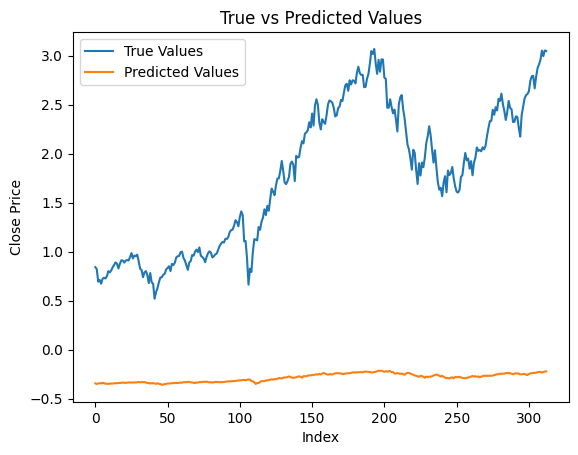

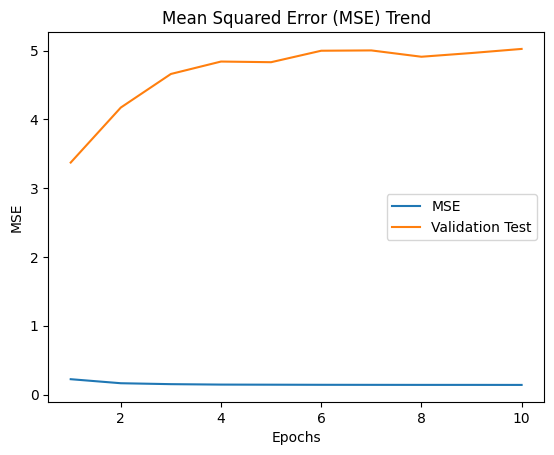

In [ ]:
#training
history = model.fit(X_train, y_train,epochs=10, batch_size=30,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(y_test, label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']
validation_values = history.history['val_loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.plot(range(1, len(validation_values) + 1), validation_values, label='Validation Test')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 10, 50)            10400     
                                                                 
 dropout_12 (Dropout)        (None, 10, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 10, 50)            20200     
                                                                 
 dropout_13 (Dropout)        (None, 10, 50)            0         
                                                                 
 dense_6 (Dense)             (None, 10, 1)             51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1/50
42/42 [==============================] - 7s 83ms/step - loss: 0.1987 - val_loss: 3.4285
Epoch 2/50
42/42 [==============================] - 1s 26ms/step - loss: 0.1548 - val_loss: 4.8052
Epoch 3/50
42/42 [==============================] - 1s 30ms/step - loss: 0.1484 - val_loss: 4.8515
Epoch 4/50
42/42 [==============================] - 1s 26ms/step - loss: 0.1451 - val_loss: 4.9017
Epoch 5/50
42/42 [==============================] - 1s 29ms/step - loss: 0.1437 - val_loss: 5.0667
Epoch 6/50
42/42 [==============================] - 1s 31ms/step - loss: 0.1432 - val_loss: 4.9696
Epoch 7/50
42/42 [==============================] - 1s 28ms/step - loss: 0.1424 - val_loss: 4.8907
Epoch 8/50
42/42 [==============================] - 1s 27ms/step - loss: 0.1425 - val_loss: 4.9246
Epoch 9/50
42/42 [==============================] - 1s 24ms/step - loss: 0.1409 - val_loss: 5.0293
Epoch 10/50
42/42 [==============================] - 2s 39ms/step - loss: 0.1407 - val_loss: 5.0574
Epoch 11/

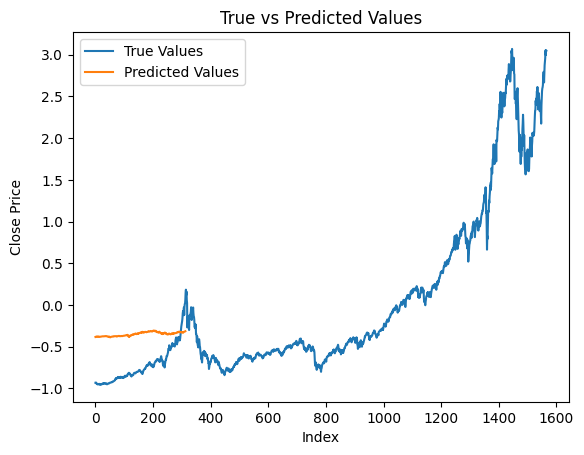

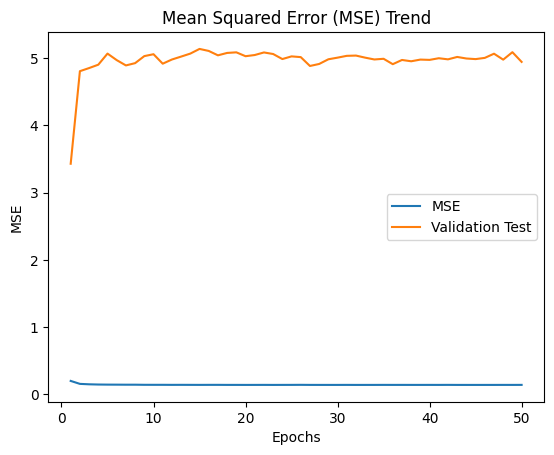

In [ ]:
#stesso modello, aumentando la finestra temporale a 10 settimane (50 epoche)
splitlimit = int(len(nasdaq_df) * 0.8)
nasdaq_df_train_set = nasdaq_df.loc[:splitlimit,:]
nasdaq_df_test_set = nasdaq_df.loc[splitlimit:,:]

X_train=[]
y_train =[]
df_days=nasdaq_df_train_set.shape[0]

for x in range(10, df_days): #prendo intanto una finestra di 5 settimane
  X_train.append(nasdaq_df.loc[x-10:x-1,'Close'])
  y_train.append(nasdaq_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))


X_test=[]
y_test =[]

for x in range(df_days, nasdaq_df.shape[0]): #prendo intanto una finestra di 5 settimane
  X_test.append(nasdaq_df.loc[x-10:x-1,'Close'])
  y_test.append(nasdaq_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))


#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')




#training
history = model.fit(X_train, y_train,epochs=50, batch_size=30,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(nasdaq_df['Close'], label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']
validation_values = history.history['val_loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.plot(range(1, len(validation_values) + 1), validation_values, label='Validation Test')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## SECONDA ARCHITETTURA: inserisco anche gli indicatori in X_train input. 10 epoche, finestra di 5 settimane

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 5, 50)             11200     
                                                                 
 dropout_14 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_15 (LSTM)              (None, 5, 50)             20200     
                                                                 
 dropout_15 (Dropout)        (None, 5, 50)             0         
                                                                 
 dense_7 (Dense)             (None, 5, 1)              51        
                                                                 
Total params: 31451 (122.86 KB)
Trainable params: 31451 (122.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1/10
33/33 [==============================] - 6s 33ms/step - loss: 0.1303 - val_loss: 3.3796
Epoch 2/10
33/33 [==============================] - 0s 10ms/step - loss: 0.0849 - val_loss: 3.5299
Epoch 3/10
33/33 [==============================] - 0s 8ms/step - loss: 0.0749 - val_loss: 3.3352
Epoch 4/10
33/33 [==============================] - 0s 9ms/step - loss: 0.0711 - val_loss: 3.4749
Epoch 5/10
33/33 [==============================] - 0s 10ms/step - loss: 0.0701 - val_loss: 3.4038
Epoch 6/10
33/33 [==============================] - 0s 10ms/step - loss: 0.0682 - val_loss: 3.3743
Epoch 7/10
33/33 [==============================] - 0s 9ms/step - loss: 0.0672 - val_loss: 3.3408
Epoch 8/10
33/33 [==============================] - 0s 10ms/step - loss: 0.0665 - val_loss: 3.4067
Epoch 9/10
33/33 [==============================] - 0s 10ms/step - loss: 0.0664 - val_loss: 3.4372
Epoch 10/10
5/5 [==============================] - 1s 4ms/step


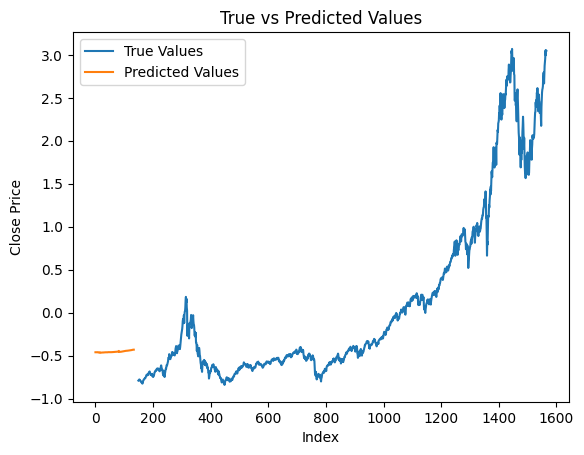

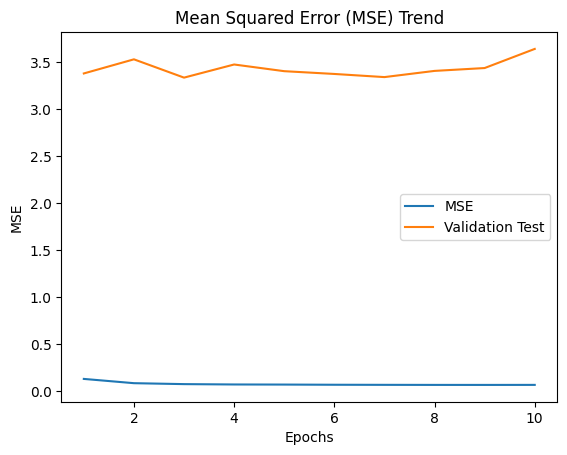

In [ ]:
def LSTM_model(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=50,
           return_sequences=True,
           input_shape =(X_train.shape[1],5))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model

nasdaq_df['RSI']=ta.rsi(nasdaq_df.Close, length=10)
nasdaq_df['EMAF']=ta.ema(nasdaq_df.Close, length=20)
nasdaq_df['EMAM']=ta.ema(nasdaq_df.Close, length=100)
nasdaq_df['EMAS']=ta.ema(nasdaq_df.Close, length=150)

nasdaq_df.dropna(inplace=True)
splitlimit = int(len(nasdaq_df) * 0.8)
nasdaq_df_train_set = nasdaq_df.loc[:nasdaq_df.index[0]+splitlimit,:] ####iloc


X_train=[]
y_train =[]
df_days=nasdaq_df_train_set.shape[0]

for x in range(nasdaq_df.index[0]+5, df_days): #prendo intanto una finestra di 5 settimane
  X_train.append(nasdaq_df.loc[x-5:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_train.append(nasdaq_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)



X_test=[]
y_test =[]

for x in range(nasdaq_df.index[0]+df_days, nasdaq_df.shape[0]): #prendo intanto una finestra di 5 settimane
  X_test.append(nasdaq_df.loc[x-5:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_test.append(nasdaq_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test) #non serve convertirlo ancora y_test è già pronto


#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')




#training
history = model.fit(X_train, y_train,epochs=10, batch_size=30,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(nasdaq_df['Close'], label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']
validation_values = history.history['val_loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.plot(range(1, len(validation_values) + 1), validation_values, label='Validation Test')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

##TERZA ARCHITETTURA

In [ ]:
nasdaq_df.index[0]+df_days,nasdaq_df.index[0] +nasdaq_df.shape[0]

(1283, 1566)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 10, 50)            11200     
                                                                 
 dropout_18 (Dropout)        (None, 10, 50)            0         
                                                                 
 lstm_19 (LSTM)              (None, 10, 50)            20200     
                                                                 
 dropout_19 (Dropout)        (None, 10, 50)            0         
                                                                 
 dense_9 (Dense)             (None, 10, 1)             51        
                                                                 
Total params: 31451 (122.86 KB)
Trainable params: 31451 (122.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1/30
44/44 [==============================] - 6s 38ms/step - loss: 0.0465 - val_loss: 0.1970
Epoch 2/30
44/44 [==============================] - 1s 13ms/step - loss: 0.0231 - val_loss: 0.1831
Epoch 3/30
44/44 [==============================] - 1s 14ms/step - loss: 0.0171 - val_loss: 0.1867
Epoch 4/30
44/44 [==============================] - 1s 13ms/step - loss: 0.0143 - val_loss: 0.2066
Epoch 5/30
44/44 [==============================] - 1s 13ms/step - loss: 0.0130 - val_loss: 0.2098
Epoch 6/30
44/44 [==============================] - 1s 13ms/step - loss: 0.0122 - val_loss: 0.2066
Epoch 7/30
44/44 [==============================] - 1s 13ms/step - loss: 0.0120 - val_loss: 0.2203
Epoch 8/30
44/44 [==============================] - 1s 13ms/step - loss: 0.0120 - val_loss: 0.2107
Epoch 9/30
44/44 [==============================] - 1s 13ms/step - loss: 0.0118 - val_loss: 0.2048
Epoch 10/30
44/44 [==============================] - 1s 13ms/step - loss: 0.0108 - val_loss: 0.2252
Epoch 11/

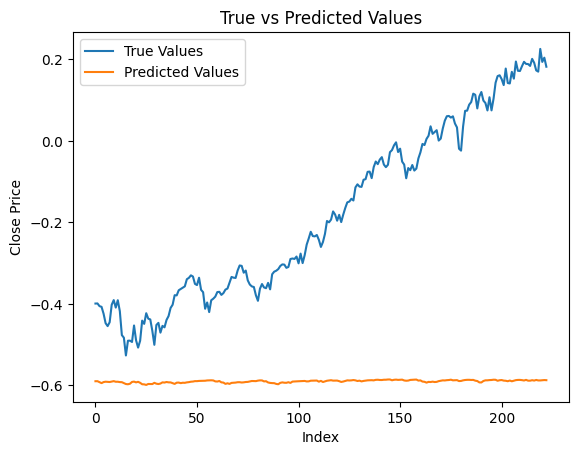

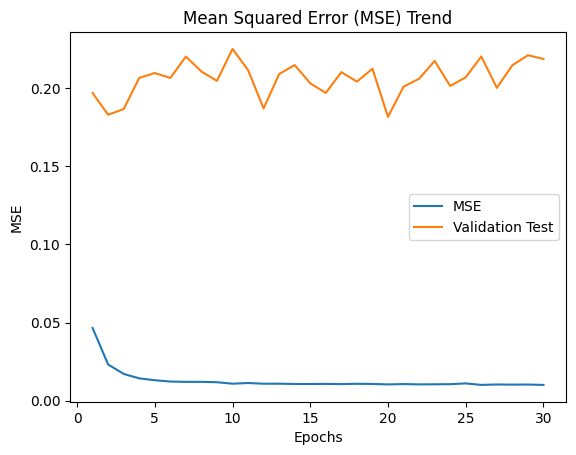

In [ ]:
#nuovo modello: inserisco anche gli indicatori in X_train input. 30 epoche, finestra di 10 settimane

def LSTM_model(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=50,
           return_sequences=True,
           input_shape =(X_train.shape[1],5))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model


nasdaq_df['RSI']=ta.rsi(nasdaq_df.Close, length=10)
nasdaq_df['EMAF']=ta.ema(nasdaq_df.Close, length=20)
nasdaq_df['EMAM']=ta.ema(nasdaq_df.Close, length=100)
nasdaq_df['EMAS']=ta.ema(nasdaq_df.Close, length=150)

nasdaq_df.dropna(inplace=True)
splitlimit = int(len(nasdaq_df) * 0.8)
nasdaq_df_train_set = nasdaq_df.loc[:nasdaq_df.index[0]+splitlimit,:] ####iloc


X_train=[]
y_train =[]
df_days=nasdaq_df_train_set.shape[0]

for x in range(nasdaq_df.index[0]+10, df_days): #prendo intanto una finestra di 10 settimane
  X_train.append(nasdaq_df.loc[x-10:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_train.append(nasdaq_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)



X_test=[]
y_test =[]

for x in range(df_days, nasdaq_df.shape[0]): #prendo intanto una finestra di 10 settimane
  X_test.append(nasdaq_df.loc[x-10:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_test.append(nasdaq_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test) #non serve convertirlo ancora y_test è già pronto


#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')




#training
history = model.fit(X_train, y_train,epochs=30, batch_size=10,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(y_test, label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']
validation_values = history.history['val_loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.plot(range(1, len(validation_values) + 1), validation_values, label='Validation Test')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()